# Sentiment Analysis using BERT

BERT (Bidirectionnal Encoder Representations for Transformers) is a “new method of pre-training language representations” developed by Google and released in late 2018.

### Import Libraries and Set the intial variables

In [1]:
import sys
sys.path.append("") 

In [2]:
# System utilities
import sys
import os
import warnings
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
# Data manipulation and processing
import numpy as np
import pandas as pd
from collections import defaultdict

# Text processing
import re
import string
from pyvi import ViTokenizer
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from matplotlib import rc

# Machine Learning and NLP
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import sklearn.metrics as metrics

# Deep Learning Libraries (TensorFlow/Keras)
import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import (
    Embedding, Conv1D, GlobalMaxPooling1D, Dense, 
    Dropout, Flatten, LSTM, MaxPooling1D, Input, 
    Reshape, GRU, Bidirectional, Input, Reshape, Conv1D, Bidirectional, LSTM, Dense, Dropout, Flatten, Attention, GlobalMaxPooling1D, Add, Multiply, Permute, Lambda, Convolution1D
)

import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter


from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers, models

# Hugging Face Transformers
from transformers import (
    BertModel, BertTokenizer, BertConfig, 
    AdamW, get_linear_schedule_with_warmup
)

# Word embeddings and NLP tools
import gensim
from gensim.models import KeyedVectors

# Model persistence
import joblib
from joblib import dump
import optuna
import yaml

# Miscellaneous settings
warnings.filterwarnings('ignore')
sys.path.append("")  # Add current directory to system path


2024-11-28 09:14:15.043587: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 09:14:15.129036: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-28 09:14:15.576038: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-11-28 09:14:15.576124: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

In [3]:
if torch.cuda.is_available():
    print("CUDA is available.")
else:
    print("Using CPU")

CUDA is available.


In [4]:
RAW_DATASET_PATH = "data/vlsp_sentiment_train.csv"
TEST_DATASET_PATH = "data/vlsp_sentiment_test.csv"
stop_words_path = "vietnamese-stopwords.txt"
MAX_LEN = 90
RANDOM_SEED =42
class_names = ['NEU', 'POS', 'NEG']
n_classes = len(class_names)
BATCH_SIZE = 128
EPOCHS = 15
lr = 1e-5
max_norm = 1.0
best_accuracy = 0
best_loss = 100
patient = 2
patient_count = 0
# Set the model name
BERT_MODEL_NAME = 'trituenhantaoio/bert-base-vietnamese-uncased'
data_path = "data/"
bert_model_path = "model/bert/"
rcnn_model_path = "model/rcnn/"
cnn_model_path = "model/cnn/"
lstm_model_path = "model/lstm/"


### Load the data

In [5]:
dataset = pd.read_csv(RAW_DATASET_PATH,  on_bad_lines='skip', delimiter="\t")

In [6]:
dataset.shape

(5100, 2)

We can see that the most relevant column for us is content and replyContent and the score as well.

In [7]:
dataset.columns

Index(['Class', 'Data'], dtype='object')

We can see that we have more positive classes than negative and low number of neutral class. I have kept neutral less to focus more on positive and negative classes. Let's allot classes based on scores now. 

* -1 - negative
* 0 - neutral 
* 1 - positive

In [8]:
dataset.describe()

,Class
count,5100.000000
mean,0.000000
std,0.816577
min,-1.000000
25%,-1.000000
50%,0.000000
75%,1.000000
max,1.000000


In [9]:
dataset=dataset.drop_duplicates("Data")
dataset = dataset.dropna()

In [10]:
dataset["Class"].value_counts()

Class
 0    1697
-1    1693
 1    1672
Name: count, dtype: int64

In [11]:
dataset["Data"].sample(40)

2736    Mình cũng dùng oke có vấn đề gì đâu nhỉ. Có mỗ...
345                            iphone đã cạn ý tưởng rồi.
4901    Nếu chỉ để ý đến chất lượng thì với tầm 6-7 tr...
3793         ý em là báo nội dung ý. Như của i5 chẳng hạn
1773    hàng xiaomi công nhận ngon bổ rẻ thật, đang dù...
5012    Các cửa hàng toàn bán hàng thay vỏ, thay màn, ...
2341                                         Ồ....rẻ nhỉ.
2827                                 Dell là trâu bò nhất
548     Mấy ai cảm nhận được sự tinh tế và đẳng cấp kh...
3276                                          Tuyệt thật.
529     Xin chúc mừng, sony đã bước được một chân ra k...
4064    Hoan nghênh nỗ lực của các bạn Mong sớm có bản...
1268    thích dùng android nhưng mấy cái dự án kiểu nà...
4615    Nói thật chứ. Giờ nghe thấy thương hiệu Lenovo...
495     Ko nhận ra bb....chán. Mình dừng lại ở BB Pass...
4711    sài dt smartphone rất dễ bị lộ thông tin và để...
741                             Tiếc cho một thương hiệu!
4253          

Vocabulary size: 14713


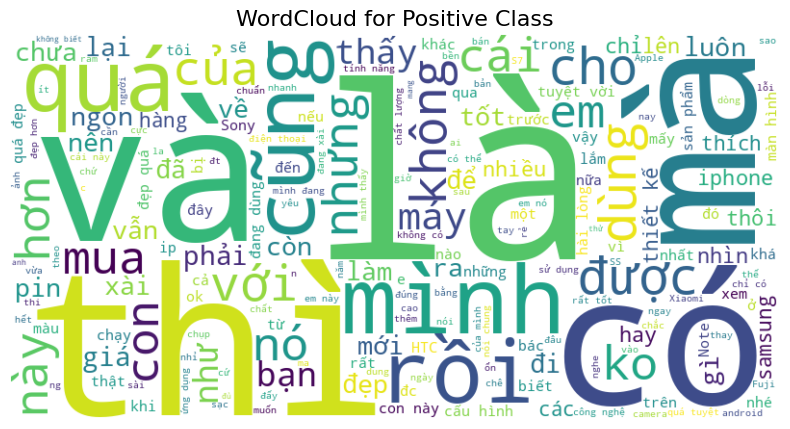

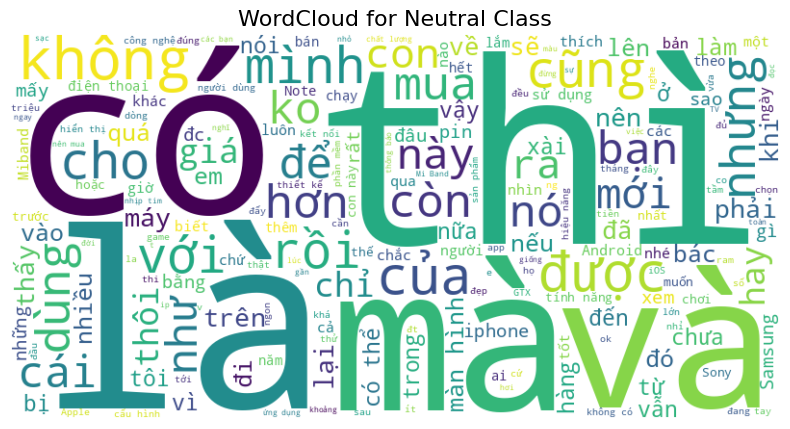

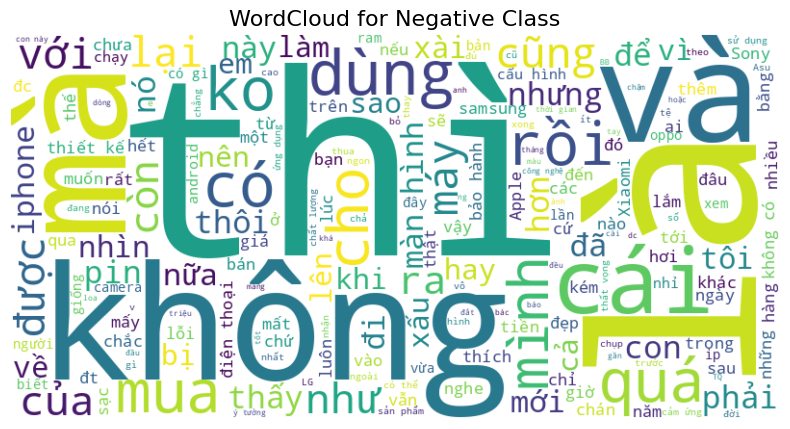

In [12]:


# Calculate Vocabulary Size
all_words = [word for text in dataset["Data"] for word in text.split()]
vocabulary = set(all_words)
vocabulary_size = len(vocabulary)
print(f"Vocabulary size: {vocabulary_size}")

# Generate WordClouds for each Class
classes = {1: "Positive", 0: "Neutral", -1: "Negative"}  # Mapping of class labels
for label, label_name in classes.items():
    # Filter texts by class
    texts = dataset[dataset["Class"] == label]["Data"]
    
    # Concatenate all texts of this class
    class_words = " ".join(texts)
    
    # Generate WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(class_words)
    
    # Plot WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"WordCloud for {label_name} Class", fontsize=16)
    plt.axis("off")
    plt.show()


In [13]:
import regex as re
import string
import json

emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)

def clean_text(text):
    text = text.lower()
    text = re.sub(emoji_pattern, " ", text)
    text = re.sub(r'([a-z]+?)\1+',r'\1', text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)
    # text = re.sub(r"(\d)([^\d.])", r"\1 \2", text)
    # text = re.sub(r"([^\d.])(\d)", r"\1 \2", text)
    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+",r"\1", text)
    text = text.strip()
    while text.endswith(tuple(string.punctuation+string.whitespace)):
        text = text[:-1]
    while text.startswith(tuple(string.punctuation+string.whitespace)):
        text = text[1:]
    text = re.sub(r"\s+", " ", text)
    return text

from pyvi import ViTokenizer

def tokenizingText(text):
    return ViTokenizer.tokenize(text)

lookup_dict = { 'sf': 'sản phẩm','cx':'cũng','kg':'kilogam', 'k':'không', 'ko':'không', 'hong':'không', 'kh':'không', 'kt':'kiểm tra', 'ktra':'kiểm tra', 'bt':'biết', 'pít': 'biết', 'píc': 'biết','v': 'với', 'sl': 'số lượng' ,'dk' : 'được', 'dc' : 'được', 'đc' : 'được' ,'chat' : 'chất' ,'okela' : 'tốt' , 'mn' : 'mọi người', 'sp' : 'sản phẩm', 'ib' : 'inbox', 'nt': 'nhắn tin', 'qc': 'quảng cáo', 'sd': 'sử dụng', 'g': 'giờ', 'dv': 'dịch vụ', 'vs': 'với', 'wa': 'qua', 'tgian' :' thời gian', 'tg' :' thời gian', 'tl' : 'trả lời', 'dx' : 'được', 'ntn' : 'như thế này', 'trc' :'trước'}

def text_std(input_text):
    words = input_text.split()
    new_words = []
    for word in words:
        word = re.sub(r'[^\w\s]','', word)
        if word.lower() in lookup_dict:
            word = lookup_dict[word.lower()]
        new_words.append(word)
    new_text = " ".join(new_words)
    return new_text

normalized_string = lambda x: " ".join(x.lower() for x in x.split())

with open(stop_words_path, 'r', encoding='utf-8') as file:
    stop_words = file.read().splitlines()

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def map_label(label):
    if label == -1:
        return 2  # NEG
    return label  # Keep other values unchanged

In [13]:
dataset["Data"] = dataset["Data"].map(lambda text: clean_text(text))
dataset["Data"] = dataset["Data"].apply(text_std)
# dataset["content"] = dataset["content"].apply(remove_stopwords)
dataset["Data"] = dataset["Data"].apply(normalized_string)
dataset["Data"] = dataset["Data"].apply(tokenizingText)
dataset["Class"] = dataset["Class"].map(map_label)

In [15]:
dataset.head(10)

,Class,Data
0,2,mình đã dùng anywhere thế_hệ đầu quả là đầy th...
1,2,quan_tâm nhất là độ trễ có cao không dùng thi_...
2,2,dag xài con cùi bắp 98k pin trâu mỗi tội đánh ...
3,2,logitech chắc hàng phải tiền triệu trở lên dùn...
4,2,đang xài con m175 cùi mía nhà xài nhiều chuột ...
5,2,đang xài 2 con m185 nút chuột giữa hai con đều...
6,2,con anywhere 1 mình dùng bị double click cũng ...
7,2,hàng cty cấp cấp xong vứt ở nhà xài con xornet...
8,2,magic mouse mà ngon hơn mới_lạ magic mouse chỉ...
9,2,em giống y bác luôn chán bluetoth kinh_hồn 1tr...


## Data Preprocessing

In [ ]:
# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [16]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 3
[CLS] 2
[PAD] 0
[UNK] 1


BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review.

In [17]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in dataset.Data:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


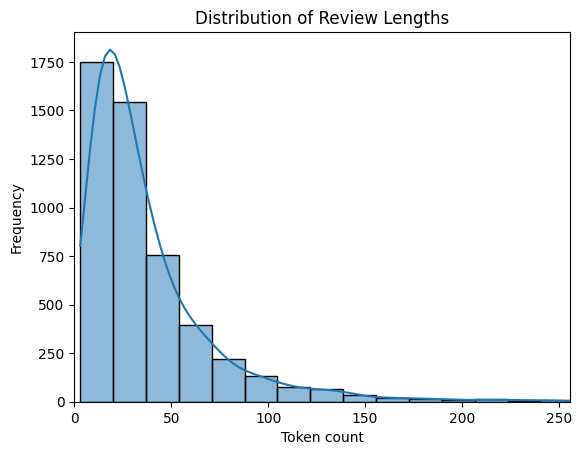

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of review lengths using histplot
sns.histplot(token_lens, kde=True, bins=30)  # `kde=True` adds the kernel density estimate
plt.xlim([0, 256])
plt.xlabel('Token count')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.show()


In [19]:
df_train, df_test = train_test_split(dataset, test_size=0.2, random_state=RANDOM_SEED,stratify=dataset['Class'])
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED, stratify=df_test['Class'])
print(df_train.shape, df_val.shape, df_test.shape)

(4049, 2) (506, 2) (507, 2)


In [20]:
from sklearn.utils import shuffle
df_train = pd.concat([df_train, df_val.sample(frac=0.62, random_state=RANDOM_SEED)])
df_train = pd.concat([df_train, df_test.sample(frac=0.5, random_state=RANDOM_SEED)])

df_train = shuffle(df_train, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(4617, 2) (506, 2) (507, 2)


In [21]:
df_train=df_train.drop_duplicates("Data")
print(df_train.shape, df_val.shape, df_test.shape)

(4589, 2) (506, 2) (507, 2)


In [22]:
# df_train.to_csv("data/train.csv", index=False)
# df_val.to_csv("data/val.csv", index=False)
# df_test.to_csv("data/test.csv", index=False)

# Create Pytorch Dataset

In [23]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [24]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.Data.to_numpy(),
        targets=df.Class.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [25]:
# Create train, test and val data loaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [26]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([128, 90])
torch.Size([128, 90])
torch.Size([128])


## Sentiment Classification with BERT

**Load the dataset**

In [27]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME)

In [28]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME)
        self.drop = nn.Dropout(p=0.5)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    
    def forward(self, input_ids, attention_mask):
            bert_output = self.bert(
              input_ids=input_ids,
              attention_mask=attention_mask
            )
            pooled_output = bert_output.pooler_output # Accessing the pooled output
            #  Add a dropout layer
            output = self.drop(pooled_output)
            return self.out(output)

In [29]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [30]:
# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [31]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for i,d in enumerate(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [32]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [33]:
history = defaultdict(list)

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val loss {val_loss} accuracy {val_acc}")
    
    history['train_acc'].append(train_acc.item())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.item())
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy and best_loss > val_loss:
        model_name = f"{bert_model_path}/model_state_{epoch}.bin"
        torch.save(model.state_dict(), model_name)
        best_accuracy = val_acc
        best_loss = val_loss
    elif(best_loss < val_loss):
        patient_count = patient_count +1
        if (patient_count >= patient):
            print("Early Stop trigger")
            break;

Epoch 1/15
----------
Train loss 1.0131098793612585 accuracy 0.48267596426236653
Val loss 0.7600554078817368 accuracy 0.6818181818181818
Epoch 2/15
----------
Train loss 0.7787889589866003 accuracy 0.6615820440183047
Val loss 0.6196052432060242 accuracy 0.7391304347826086
Epoch 3/15
----------
Train loss 0.5886105042364862 accuracy 0.766179995641752
Val loss 0.5474713146686554 accuracy 0.8023715415019762
Epoch 4/15
----------
Train loss 0.4052496941553222 accuracy 0.8522553933318806
Val loss 0.5088929608464241 accuracy 0.8280632411067194
Epoch 5/15
----------
Train loss 0.2854251799484094 accuracy 0.900631945957725
Val loss 0.47777657210826874 accuracy 0.8517786561264822
Epoch 6/15
----------
Train loss 0.21742048797508082 accuracy 0.9232948354761386
Val loss 0.5048747360706329 accuracy 0.8656126482213438
Epoch 7/15
----------
Train loss 0.1413873260219892 accuracy 0.9529309217694487
Val loss 0.47335823625326157 accuracy 0.8636363636363635
Epoch 8/15
----------
Train loss 0.10356352323

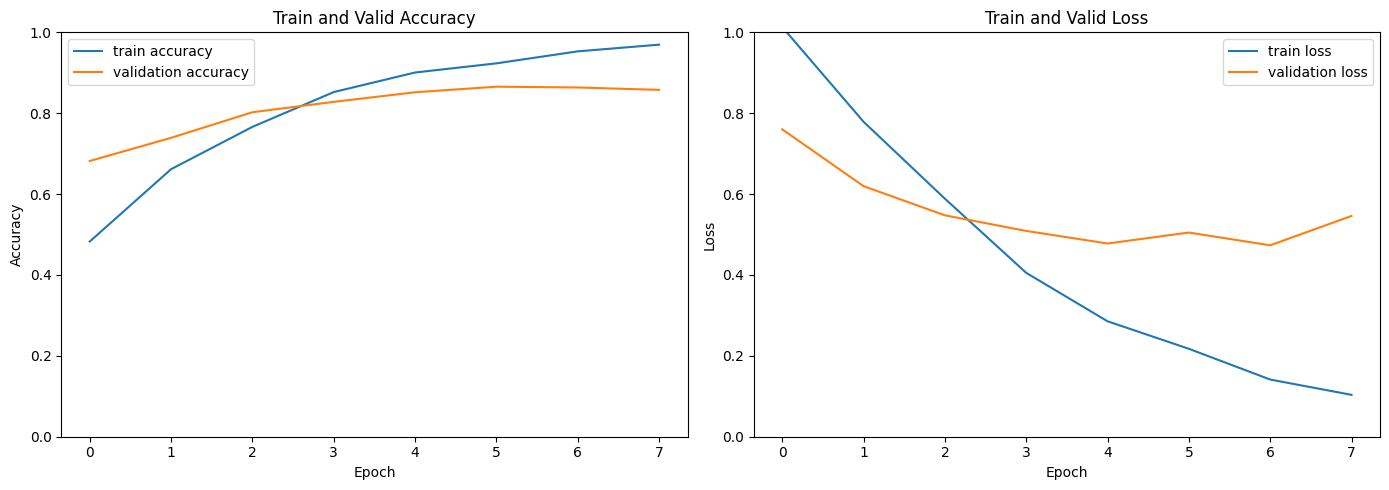

In [34]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot training and validation loss on the first subplot (left)
ax2.plot(history['train_loss'], label='train loss')
ax2.plot(history['val_loss'], label='validation loss')
ax2.set_title('Train and Valid Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()
ax2.set_ylim([0, 1])

# Plot training and validation accuracy on the second subplot (right)
ax1.plot(history['train_acc'], label='train accuracy')
ax1.plot(history['val_acc'], label='validation accuracy')
ax1.set_title('Train and Valid Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()
ax1.set_ylim([0, 1])

# Display the plots
plt.tight_layout()
plt.show()


# Test model

In [35]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8185404339250494

In [36]:
# Lưu tokenizer
tokenizer.save_pretrained(bert_model_path)

('model/bert/tokenizer_config.json',
 'model/bert/special_tokens_map.json',
 'model/bert/vocab.txt',
 'model/bert/added_tokens.json')

In [37]:

# Tải cấu hình của mô hình từ tệp config.json
config = BertConfig.from_pretrained(BERT_MODEL_NAME)

# Tải tokenizer từ thư mục chứa các tệp nhị phân đã lưu trữ
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

# Tải mô hình từ thư mục chứa các tệp nhị phân đã lưu trữ
model_bert_sentiment = SentimentClassifier(n_classes = n_classes)
model_bert_sentiment.load_state_dict(torch.load('model/bert/model_state_3.bin'))

# Đảm bảo mô hình ở chế độ evaluation
model_bert_sentiment.eval()
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model_bert_sentiment.to(device)

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [38]:
test_acc, _ = eval_model(
  model_bert_sentiment,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.7909270216962525

In [39]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [40]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model_bert_sentiment,
    test_data_loader
)

In [41]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         NEU       0.76      0.79      0.78       170
         POS       0.76      0.90      0.82       167
         NEG       0.88      0.68      0.77       170

    accuracy                           0.79       507
   macro avg       0.80      0.79      0.79       507
weighted avg       0.80      0.79      0.79       507



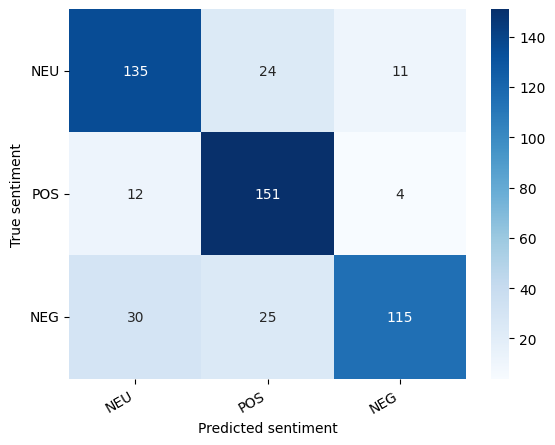

In [42]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [43]:
review_text = "Sản phẩm này cũng bình thường, xài cũng được, không tốt không xấu"

In [44]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
    truncation=True
)

In [45]:
import torch.nn.functional as F

input_ids = encoded_review['input_ids'].to('cuda')
attention_mask = encoded_review['attention_mask'].to('cuda')

output = model_bert_sentiment(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)


probs = F.softmax(output, dim=1)

for i, class_name in enumerate(class_names):
    print(f'{class_name} probability: {probs[0][i].item():.4f}')

# In ra review text và nhãn dự đoán
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')


NEU probability: 0.0125
POS probability: 0.9189
NEG probability: 0.0687
Review text: Sản phẩm này cũng bình thường, xài cũng được, không tốt không xấu
Sentiment  : POS


# Real test

In [46]:
test_dataset = pd.read_csv(TEST_DATASET_PATH,  on_bad_lines='skip', delimiter="\t")

In [47]:
test_dataset["Class"] = test_dataset["Class"].map(map_label)

In [48]:
real_test_data_loader = create_data_loader(test_dataset, tokenizer, MAX_LEN, BATCH_SIZE)

In [49]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model_bert_sentiment,
    real_test_data_loader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [50]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         NEU       0.62      0.65      0.63       350
         POS       0.63      0.78      0.69       350
         NEG       0.74      0.53      0.62       350

    accuracy                           0.65      1050
   macro avg       0.66      0.65      0.65      1050
weighted avg       0.66      0.65      0.65      1050



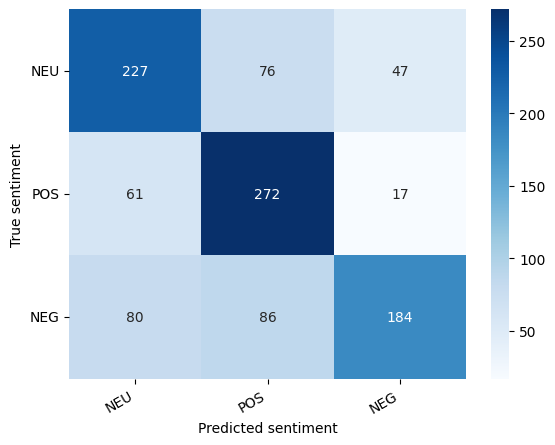

In [51]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [52]:
def calculate_accuracy(y_test, y_pred):
    """
    Calculate the accuracy given ground truth labels and predictions.

    Args:
        y_test (torch.Tensor): Ground truth labels.
        y_pred (torch.Tensor): Predicted labels.

    Returns:
        float: Accuracy as a percentage.
    """
    # Ensure both tensors are on the same device
    y_test = y_test.to(y_pred.device)
    
    # Compare predictions with ground truth and calculate accuracy
    correct = (y_test == y_pred).sum().item()
    total = y_test.size(0)
    accuracy = correct / total * 100  # Convert to percentage
    return accuracy


In [53]:
accuracy = calculate_accuracy(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 65.05%


# **RCNN**

In [16]:
import tensorflow as tf
print(tf.keras.__version__)
print(tf.__version__)

2.11.0
2.11.0


In [17]:
df_train = pd.read_csv('data/train.csv')
df_val = pd.read_csv("data/val.csv")
df_test = pd.read_csv("data/test.csv")

In [18]:
def TokenizingText(text):
    return ViTokenizer.tokenize(text)

In [19]:
df_train['Data']= df_train['Data'].apply(TokenizingText)
df_val['Data']= df_val['Data'].apply(TokenizingText)
df_test['Data']= df_test['Data'].apply(TokenizingText)

In [20]:
X_train = df_train['Data']
X_val = df_val['Data']
X_test = df_test['Data']

Y_train = df_train['Class']
Y_val = df_val['Class']
Y_test = df_test['Class']

## Create tfidf and svd

In [21]:
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=30000)
tfidf_vect.fit(X_train) 
X_train_tfidf =  tfidf_vect.transform(X_train)
X_val_tfidf =  tfidf_vect.transform(X_val)
X_test_tfidf =  tfidf_vect.transform(X_test)

In [27]:
svd = TruncatedSVD(n_components=300, random_state=42)
svd.fit(X_train_tfidf)
X_train_tfidf_svd = svd.transform(X_train_tfidf)
X_val_tfidf_svd = svd.transform(X_val_tfidf)
X_test_tfidf_svd = svd.transform(X_test_tfidf)

In [25]:
tf.keras.backend.clear_session()

In [26]:
RCNN_model = Sequential()

RCNN_model.add(Input(shape=(300,)))
RCNN_model.add(Reshape((10, 30)))
RCNN_model.add(Bidirectional(GRU(128, activation='relu', return_sequences=True)))
RCNN_model.add(Convolution1D(100, 3, activation="relu"))
RCNN_model.add(Flatten())
RCNN_model.add(Dense(512, activation='relu'))
RCNN_model.add(Dense(512, activation='relu'))
RCNN_model.add(Dense(128, activation='relu'))
RCNN_model.add(Dense(3, activation='softmax'))
RCNN_model.summary()

RCNN_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Define ModelCheckpoint to save the best model based on validation loss
checkpoint_filepath = f"{rcnn_model_path}/best_model_weights.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Save only weights
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    verbose=1
)

# Train the model
history = RCNN_model.fit(
    X_train_tfidf_svd,
    Y_train,
    validation_data=(X_val_tfidf_svd, Y_val),
    epochs=15,
    batch_size=64,
    callbacks=[early_stop, checkpoint_callback]
)

# Load the best weights after training
RCNN_model.load_weights(checkpoint_filepath)

# Evaluate the model on the validation and test sets
val_predictions = RCNN_model.predict(X_val_tfidf_svd).argmax(axis=-1)
test_predictions = RCNN_model.predict(X_test_tfidf_svd).argmax(axis=-1)

print("Validation accuracy: ", metrics.accuracy_score(val_predictions, Y_val))
print("Test accuracy: ", metrics.accuracy_score(test_predictions, Y_test))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 10, 30)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 10, 256)          122880    
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, 8, 100)            76900     
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 512)               410112    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                        

2024-11-27 11:34:09.486700: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-27 11:34:09.611972: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-27 11:34:09.612019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-27 11:34:09.613929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other ope

                                                                 
Total params: 938,599
Trainable params: 938,599
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15


2024-11-27 11:34:12.101793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-27 11:34:13.762576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2024-11-27 11:34:15.486356: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f098401df10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-27 11:34:15.486393: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-11-27 11:34:15.502760: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-27 11:34:15.696087: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of 

72/72 [==============================] - ETA: 0s - loss: 1.0492 - accuracy: 0.4156
Epoch 1: val_loss improved from inf to 0.91445, saving model to model/rcnn/best_model_weights.h5
72/72 [==============================] - 12s 69ms/step - loss: 1.0492 - accuracy: 0.4156 - val_loss: 0.9144 - val_accuracy: 0.5395
Epoch 2/15
72/72 [==============================] - ETA: 0s - loss: 0.9236 - accuracy: 0.5326
Epoch 2: val_loss improved from 0.91445 to 0.87826, saving model to model/rcnn/best_model_weights.h5
72/72 [==============================] - 5s 66ms/step - loss: 0.9236 - accuracy: 0.5326 - val_loss: 0.8783 - val_accuracy: 0.5810
Epoch 3/15
72/72 [==============================] - ETA: 0s - loss: 0.8412 - accuracy: 0.6106
Epoch 3: val_loss improved from 0.87826 to 0.80738, saving model to model/rcnn/best_model_weights.h5
72/72 [==============================] - 5s 65ms/step - loss: 0.8412 - accuracy: 0.6106 - val_loss: 0.8074 - val_accuracy: 0.6443
Epoch 4/15
72/72 [=====================

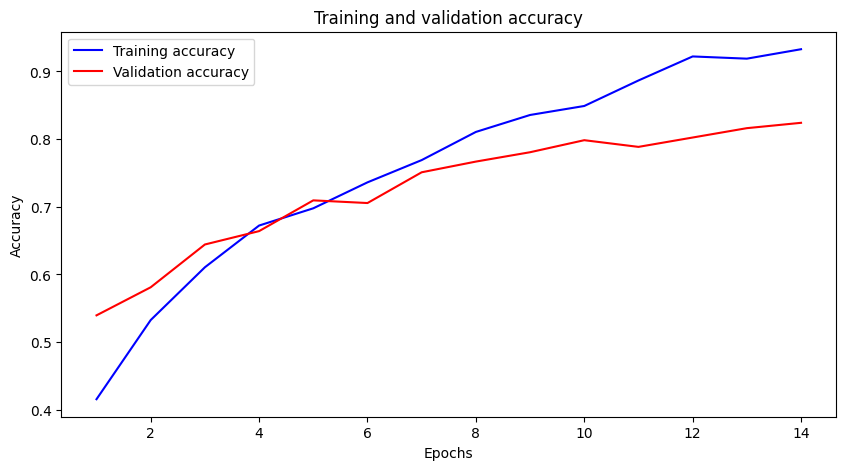

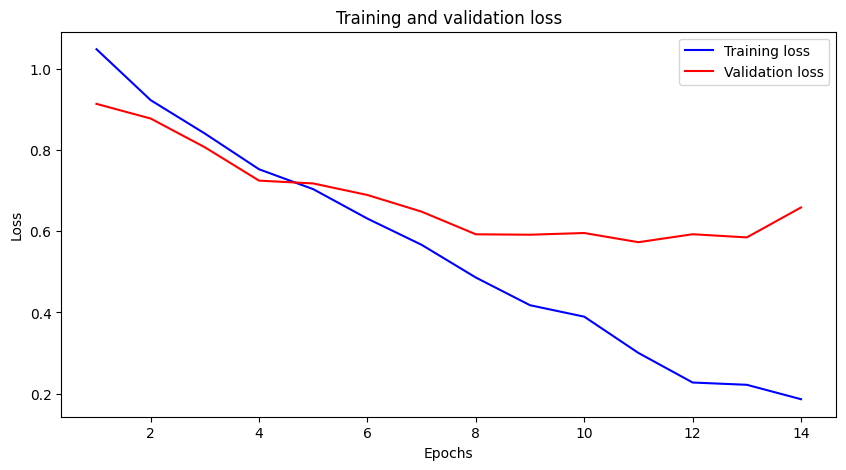

In [27]:
def plot_history(history):
    # Lấy các giá trị từ lịch sử huấn luyện
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_accuracy) + 1)

    # Vẽ đồ thị độ chính xác
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Vẽ đồ thị mất mát
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history)

In [28]:

# Tính toán classification report trên tập dữ liệu kiểm tra
class_report = classification_report(Y_test, test_predictions, target_names=class_names)

# Hiển thị classification report
print("Classification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

         NEU       0.78      0.77      0.78       170
         POS       0.80      0.86      0.83       167
         NEG       0.81      0.77      0.79       170

    accuracy                           0.80       507
   macro avg       0.80      0.80      0.80       507
weighted avg       0.80      0.80      0.80       507



In [29]:
def plot_confusion_matrix(conf_matrix, class_names):
    """
    Plot a confusion matrix using Seaborn heatmap.
    
    Args:
        conf_matrix (np.ndarray): Confusion matrix.
        class_names (list): List of class names.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

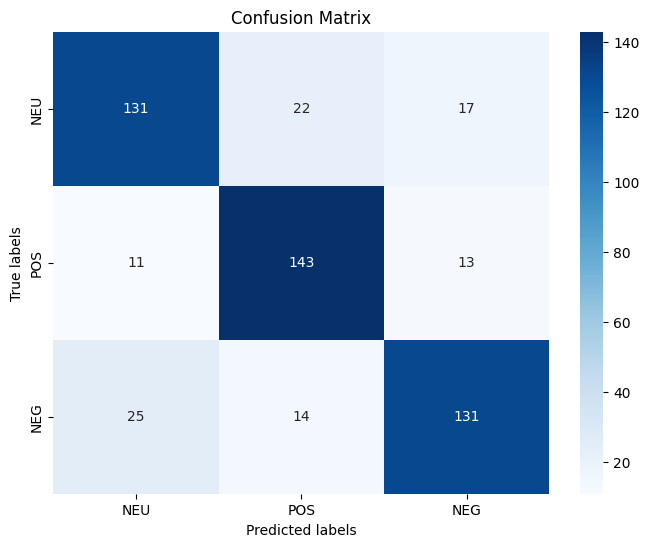

In [30]:
# Tính toán confusion matrix trên tập dữ liệu kiểm tra
conf_matrix = confusion_matrix(Y_test, test_predictions)
plot_confusion_matrix(conf_matrix, class_names=class_names)


In [31]:
# Đánh giá mô hình trên tập test
test_loss, test_accuracy = RCNN_model.evaluate(X_test_tfidf_svd, Y_test)

print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)


16/16 [==============================] - 0s 9ms/step - loss: 0.6215 - accuracy: 0.7988
Test Accuracy: 0.7988165616989136
Test Loss: 0.6215152144432068


In [32]:
for i in range(len(RCNN_model.weights)):
    RCNN_model.weights[i]._handle_name = RCNN_model.weights[i].name + "_" + str(i)

In [33]:
RCNN_model.save(f"{rcnn_model_path}/RCNN_model.h5")
dump(tfidf_vect, f"{rcnn_model_path}/tfidf_model.joblib")
dump(svd, f"{rcnn_model_path}/svd_model.joblib")


['model/rcnn//svd_model.joblib']

In [34]:
svd = joblib.load(f"{rcnn_model_path}/svd_model.joblib")
tfidf = joblib.load(f"{rcnn_model_path}/tfidf_model.joblib")
RCNN_model.load_weights(f"{rcnn_model_path}/RCNN_model.h5")


In [35]:
def sentiment_predict(model, text, class_names:list):
    """
    Predict sentiment for a given text using the RCNN model.

    Args:
        text (str): Input text for sentiment analysis.
    
    Returns:
        None
    """
    # Ensure the input is wrapped in a list
    text_tfidf = tfidf.transform([text])  # Wrap the string in a list
    text_svd = svd.transform(text_tfidf)
    predictions = RCNN_model.predict(text_svd)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]
    probabilities = predictions[0]

    return predicted_class, probabilities

In [36]:
sentiment_predict(model=RCNN_model, text = "cái bát này thực sự tệ, tôi rất ghét nó", class_names=class_names)

1/1 [==============================] - 0s 40ms/step


('NEG', array([0.00851655, 0.01696685, 0.97451663], dtype=float32))

## Real test

In [43]:
test_dataset = pd.read_csv(TEST_DATASET_PATH,  on_bad_lines='skip', delimiter="\t")
test_dataset.head()

,Class,Data
0,-1,Nói thiệt là mình thì thì chuột nào mình cũng ...
1,-1,Đang dùng mx1. Cũng ngon nhưng chưa đầy năm mà...
2,-1,"Chưa thấy đc điểm thuyết phục để mua, nhất là ..."
3,-1,"Những phần xem báo tra cứu bản đồ, dịch vụ.. d..."
4,-1,ĐÚNG LÀ MUA Ở VIỆT NAM KHÔNG ỨNG DỤNG ĐƯỢC GÌ ...


In [ ]:
# test_dataset["Data"] = test_dataset["Data"].map(lambda text: clean_text(text))
# test_dataset["Data"] = test_dataset["Data"].apply(text_std)
# # dataset["content"] = dataset["content"].apply(remove_stopwords)
# test_dataset["Data"] = test_dataset["Data"].apply(normalized_string)
# test_dataset["Data"] = test_dataset["Data"].apply(tokenizingText)
# # test_dataset["Class"] = test_dataset["Class"].map(map_label)

In [45]:
def evaluate_model(test_df, model, tfidf, svd, class_names):
    """
    Evaluate the given model on a test dataset.
    
    Args:
        test_df (pd.DataFrame): The test dataset containing 'Text' and 'Class' columns.
        model: Trained RCNN model for prediction.
        tfidf: TF-IDF transformer for preprocessing.
        svd: SVD transformer for dimensionality reduction.
        class_names (list): List of class names in order of indices.
        
    Returns:
        dict: Dictionary containing accuracy and confusion matrix.
    """
    # Preprocess the test data
    texts = test_df['Data'].values
    true_labels = test_df['Class'].values

    # Transform the texts using TF-IDF and SVD
    texts_tfidf = tfidf.transform(texts)
    texts_svd = svd.transform(texts_tfidf)

    # Predict using the model
    predictions = model.predict(texts_svd)
    predicted_indices = np.argmax(predictions, axis=1)

    # Map predicted indices to actual labels
    index_to_label = {0: 0, 1: 1, 2: -1}  # Mapping model outputs to actual labels
    predicted_classes = np.array([index_to_label[idx] for idx in predicted_indices])

    # Calculate confusion matrix and accuracy
    conf_matrix = confusion_matrix(true_labels, predicted_classes)
    accuracy = accuracy_score(true_labels, predicted_classes)

    # Print results
    print(f"Model Accuracy: {accuracy:.2%}")

    # Plot confusion matrix
    class_report = classification_report(true_labels, predicted_classes, target_names=class_names)

    # Hiển thị classification report
    print("Classification Report:\n", class_report)
    plot_confusion_matrix(conf_matrix, class_names)

    # Return metrics as a dictionary
    return {
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix
    }


33/33 [==============================] - 0s 11ms/step
Model Accuracy: 59.81%
Classification Report:
               precision    recall  f1-score   support

         NEU       0.60      0.63      0.62       350
         POS       0.56      0.53      0.55       350
         NEG       0.63      0.63      0.63       350

    accuracy                           0.60      1050
   macro avg       0.60      0.60      0.60      1050
weighted avg       0.60      0.60      0.60      1050



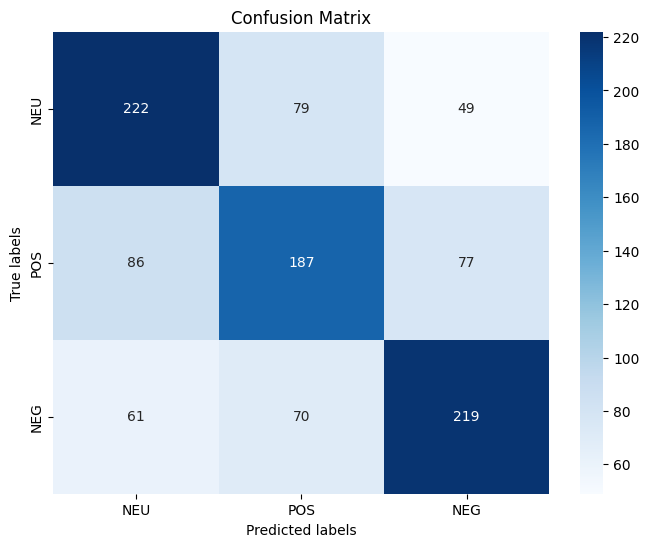

0.5980952380952381


In [46]:
results = evaluate_model(test_dataset, RCNN_model, tfidf, svd, class_names)
print(results['accuracy'])

# CNN

In [47]:

# Define the CNN model
CNN_model = Sequential()

# Input layer
CNN_model.add(Input(shape=(300,)))

# Reshape layer to prepare input for 1D Convolutions
CNN_model.add(Reshape((10, 30)))

# Convolutional layers
CNN_model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
CNN_model.add(MaxPooling1D(pool_size=2))

CNN_model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
CNN_model.add(MaxPooling1D(pool_size=2))

# Flatten layer
CNN_model.add(Flatten())

# Dense layers
CNN_model.add(Dense(512, activation='relu'))
CNN_model.add(Dense(128, activation='relu'))

# Output layer (softmax for multiclass classification)
CNN_model.add(Dense(3, activation='softmax'))

# Model summary
CNN_model.summary()

# Compile the model
CNN_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Model checkpoint callback
os.makedirs(cnn_model_path, exist_ok=True)

checkpoint_filepath = f"{cnn_model_path}/model_weights-{{epoch:02d}}.weights.h5"

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_freq='epoch',  # Save after every epoch
    save_best_only=True,  # Save only the best model
    verbose=1
)

# Train the model
history = CNN_model.fit(
    X_train_tfidf_svd, Y_train,
    validation_data=(X_val_tfidf_svd, Y_val),
    epochs=15,
    batch_size=64,
    callbacks=[early_stop, checkpoint_callback]
)

# Evaluate on validation and test sets
val_predictions = CNN_model.predict(X_val_tfidf_svd)
test_predictions = CNN_model.predict(X_test_tfidf_svd)

# Convert probabilities to class indices
val_predictions = val_predictions.argmax(axis=-1)
test_predictions = test_predictions.argmax(axis=-1)

# Calculate accuracy
print("Validation accuracy: ", accuracy_score(Y_val, val_predictions))
print("Test accuracy: ", accuracy_score(Y_test, test_predictions))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 10, 30)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 128)           11648     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 128)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 64)             24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 128)              

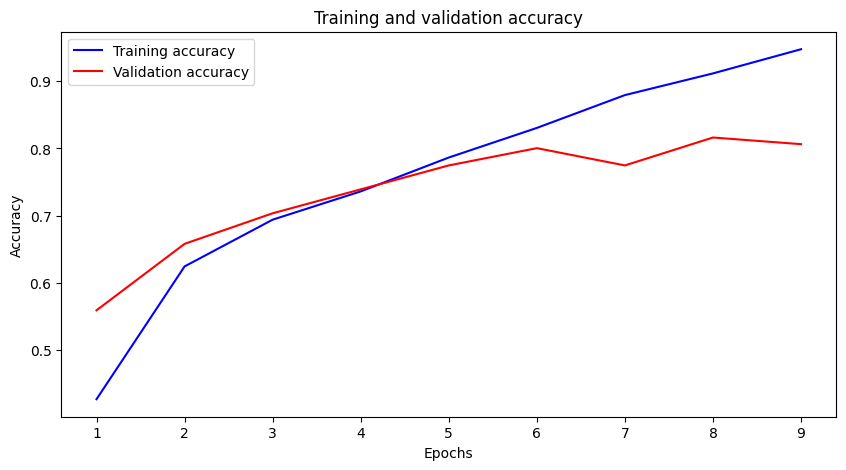

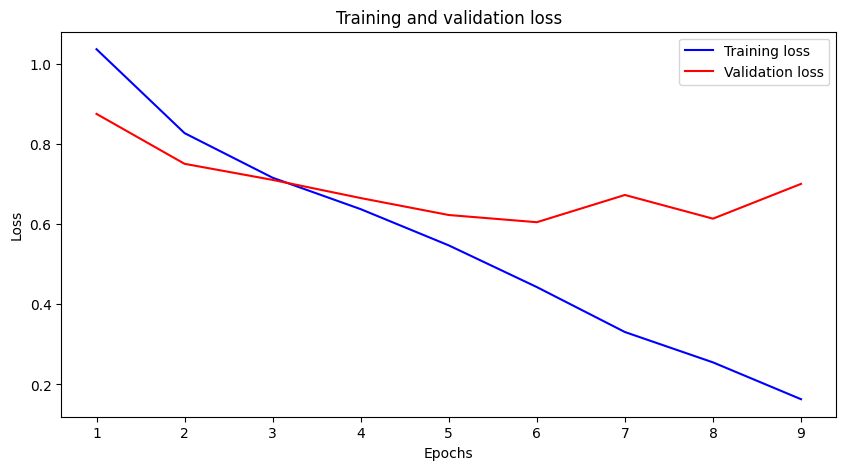

In [48]:
plot_history(history=history)

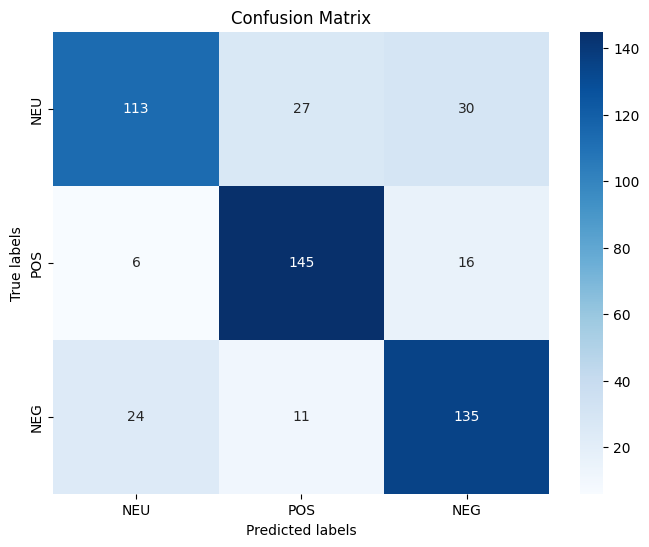

In [49]:
# Tính toán confusion matrix trên tập dữ liệu kiểm tra
conf_matrix = confusion_matrix(Y_test, test_predictions)
plot_confusion_matrix(conf_matrix, class_names=class_names)

## Real test

33/33 [==============================] - 0s 2ms/step
Model Accuracy: 58.67%
Classification Report:
               precision    recall  f1-score   support

         NEU       0.58      0.61      0.59       350
         POS       0.60      0.48      0.53       350
         NEG       0.59      0.67      0.63       350

    accuracy                           0.59      1050
   macro avg       0.59      0.59      0.58      1050
weighted avg       0.59      0.59      0.58      1050



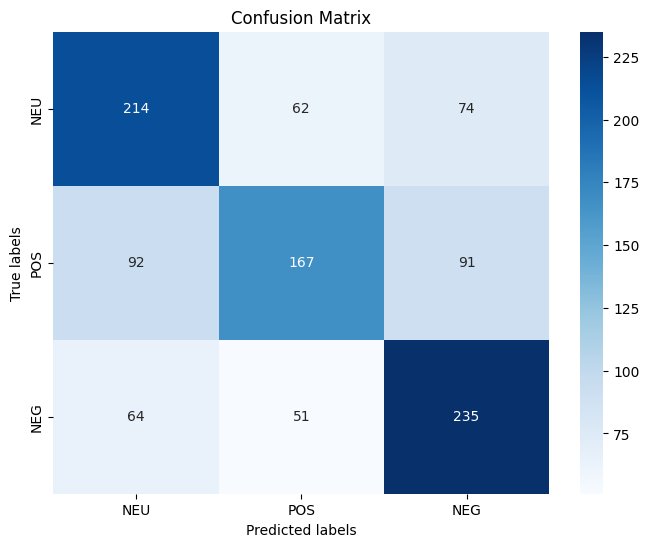

0.5866666666666667


In [50]:
results = evaluate_model(test_dataset, CNN_model, tfidf, svd, class_names)
print(results['accuracy'])

# LSTM

In [51]:
# Define the LSTM model
LSTM_model = Sequential()

# Input layer
LSTM_model.add(Input(shape=(300,)))

# Reshape layer to prepare input for LSTM
LSTM_model.add(Reshape((10, 30)))

# Bidirectional LSTM layer
LSTM_model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True)))

# Flatten layer
LSTM_model.add(Flatten())

# Dense layers
LSTM_model.add(Dense(512, activation='relu'))
LSTM_model.add(Dense(128, activation='relu'))

# Output layer (softmax for multiclass classification)
LSTM_model.add(Dense(3, activation='softmax'))

# Model summary
LSTM_model.summary()

# Compile the model
LSTM_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Model checkpoint callback
os.makedirs(lstm_model_path, exist_ok=True)

checkpoint_filepath = f"{lstm_model_path}/model_weights-{{epoch:02d}}.weights.h5"

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_freq='epoch',  # Save after every epoch
    save_best_only=True,  # Save only the best model
    verbose=1
)

# Train the model
history = LSTM_model.fit(
    X_train_tfidf_svd, Y_train,
    validation_data=(X_val_tfidf_svd, Y_val),
    epochs=15,
    batch_size=64,
    callbacks=[early_stop, checkpoint_callback]
)

# Evaluate on validation and test sets
val_predictions = LSTM_model.predict(X_val_tfidf_svd)
test_predictions = LSTM_model.predict(X_test_tfidf_svd)

# Convert probabilities to class indices
val_predictions = val_predictions.argmax(axis=-1)
test_predictions = test_predictions.argmax(axis=-1)

# Calculate accuracy
print("Validation accuracy: ", accuracy_score(Y_val, val_predictions))
print("Test accuracy: ", accuracy_score(Y_test, test_predictions))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 10, 30)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 10, 256)          162816    
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 2560)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               1311232   
                                                                 
 dense_8 (Dense)             (None, 128)               65664     
                                                                 
 dense_9 (Dense)             (None, 3)                 387       
                                                      

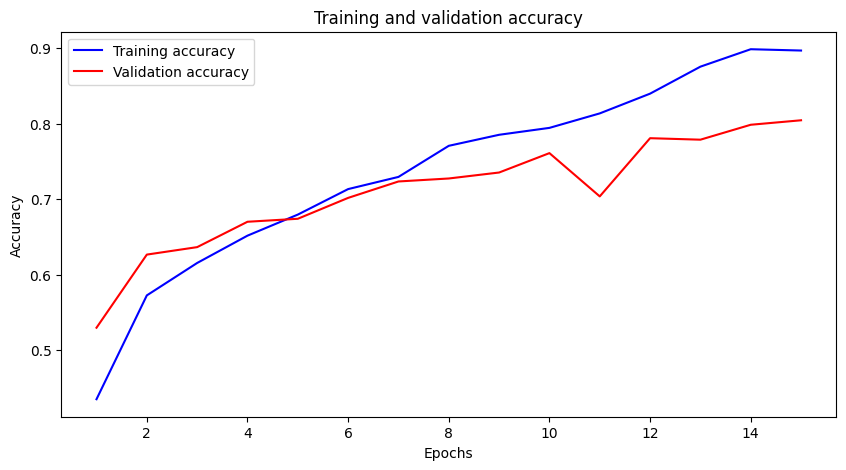

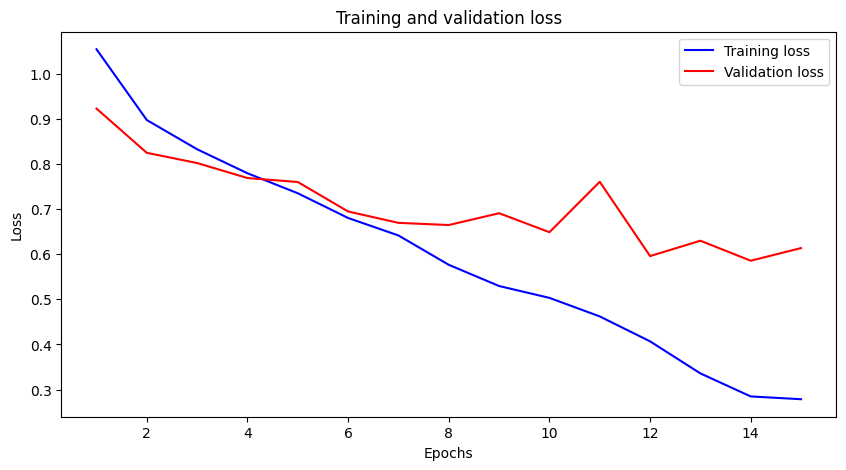

In [52]:
plot_history(history=history)


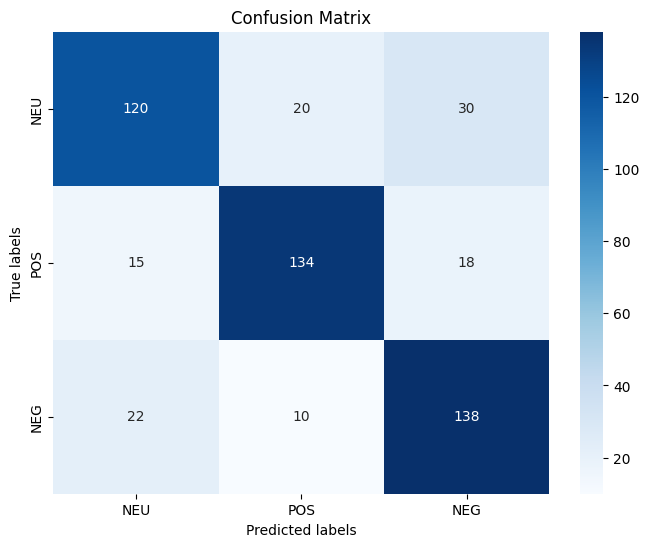

In [53]:
# Tính toán confusion matrix trên tập dữ liệu kiểm tra
conf_matrix = confusion_matrix(Y_test, test_predictions)
plot_confusion_matrix(conf_matrix, class_names=class_names)

## Real test

33/33 [==============================] - 0s 7ms/step
Model Accuracy: 62.29%
Classification Report:
               precision    recall  f1-score   support

         NEU       0.59      0.67      0.62       350
         POS       0.60      0.60      0.60       350
         NEG       0.70      0.60      0.65       350

    accuracy                           0.62      1050
   macro avg       0.63      0.62      0.62      1050
weighted avg       0.63      0.62      0.62      1050



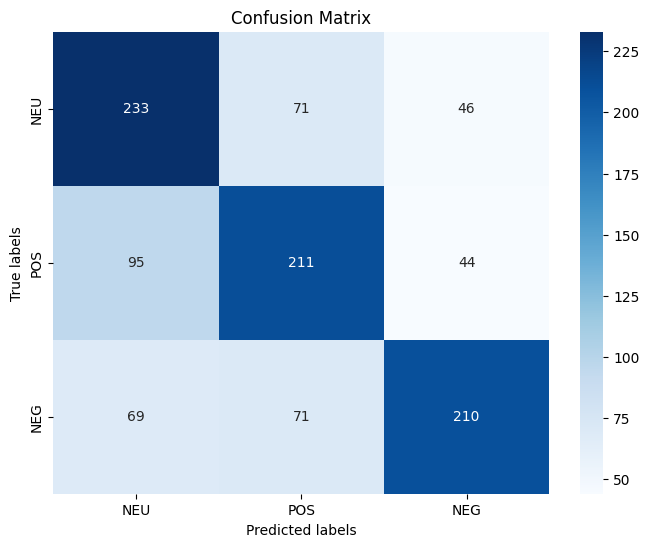

0.6228571428571429


In [54]:
results = evaluate_model(test_dataset, LSTM_model, tfidf, svd, class_names)
print(results['accuracy'])